Bernstein-Vazirani Benchmark Program - Braket
... execution starting at Jun 10, 2024 05:02:27 UTC
************
Executing [3] circuits with num_qubits = 3
Average Creation, Elapsed, Execution Time for the 3 qubit group = 0.0, 0.012, 0.012 secs
Average Hellinger, Normalized Fidelity for the 3 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 4
Average Creation, Elapsed, Execution Time for the 4 qubit group = 0.0, 0.009, 0.009 secs
Average Hellinger, Normalized Fidelity for the 4 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 5
Average Creation, Elapsed, Execution Time for the 5 qubit group = 0.0, 0.01, 0.01 secs
Average Hellinger, Normalized Fidelity for the 5 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 6
Average Creation, Elapsed, Execution Time for the 6 qubit group = 0.0, 0.01, 0.01 secs
Average Hellinger, Normalized Fidelity for the 6 qubit group = 1.0, 1.0

************
Executing [3] circuit

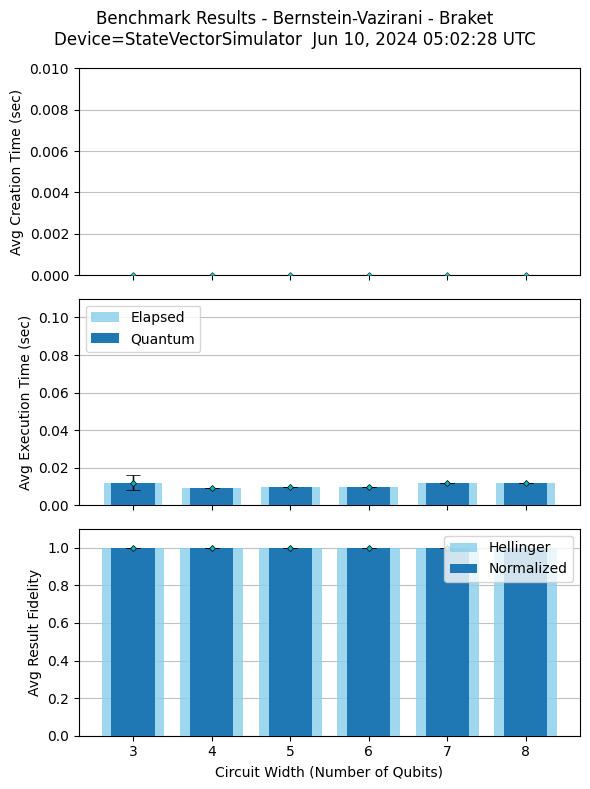

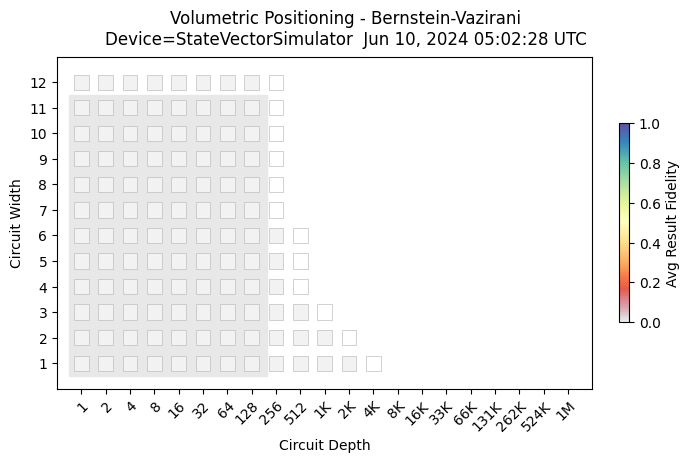

In [1]:
"""
Bernstein-Vazirani Benchmark Program - Braket
"""

import sys
import time

from braket.circuits import Circuit      # AWS imports: Import Braket SDK modules
import numpy as np

sys.path[1:1] = [ "_common", "_common/braket" ]
sys.path[1:1] = [ "../../_common", "../../_common/braket" ]
import execute as ex
import metrics as metrics

np.random.seed(0)

verbose = False

# saved circuits for display
QC_ = None
Uf_ = None

############### Circuit Definition
def create_oracle(input_size, secret_int):
    qc = Circuit()

    # perform CX for each qubit that matches a bit in secret string
    s = ('{0:0'+str(input_size)+'b}').format(secret_int)
    for i_qubit in range(input_size):
        if s[input_size-1-i_qubit]=='1':
            qc.cnot(i_qubit, input_size)

    #qc = braket_utils.to_gate(num_qubits=num_qubits, circ=qc, name="Uf")

    return qc

def BersteinVazirani (num_qubits, secret_int):
    
    # size of input is one less than available qubits
    input_size = num_qubits - 1
    
    qc = Circuit()
    
    # put ancilla in superposition
    qc.x(num_qubits-1)
    
    # start with Hadamard on all qubits, including ancilla
    for i_qubit in range(num_qubits):
         qc.h(i_qubit)

    Uf = create_oracle(input_size, secret_int)
    qc.add(Uf)

    # end with Hadamard on all qubits, including ancilla
    for i_qubit in range(num_qubits):
         qc.h(i_qubit)

    # uncompute ancilla qubit, not necessary for algorithm
    qc.x(input_size)
    
    # save smaller circuit example for display
    global QC_, Uf_
    if QC_ == None or num_qubits <= 6:
        if num_qubits < 9: QC_ = qc
    if Uf_ == None or num_qubits <= 6:
        if num_qubits < 9: Uf_ = Uf

    # return a handle on the circuit
    return qc       
        
############### Result Data Analysis

# Analyze and print measured results
# Expected result is always the secret_int, so fidelity calc is simple
def analyze_and_print_result (qc, result, num_qubits, secret_int):

    # size of input is one less than available qubits
    input_size = num_qubits - 1

    # obtain shots from the result metadata
    num_shots = result.task_metadata.shots

    # obtain counts from the result object
    # for braket, need to reverse the key to match binary order
    # for braket, measures all qubits, so we have to remove data qubit measurement
    counts_r = result.measurement_counts
    counts = {}
    for measurement_r in counts_r.keys():
        measurement = measurement_r[:-1][::-1] # remove data qubit and reverse order
        if measurement in counts:
            counts[measurement] += counts_r[measurement_r]
        else:
            counts[measurement] = counts_r[measurement_r]

    if verbose: print(f"For secret int {secret_int} measured: {counts}")
    
    # create the key that is expected to have all the measurements (for this circuit)
    key = format(secret_int, f"0{input_size}b")    

    # correct distribution is measuring the key 100% of the time
    correct_dist = {key: 1.0}

    # use our polarization fidelity rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist)
    
    return counts, fidelity


################ Benchmark Loop
        
# Execute program with default parameters
def run (min_qubits=3, max_qubits=8, max_circuits=3, num_shots=1000, backend_id='simulator'):

    print("Bernstein-Vazirani Benchmark Program - Braket")

    # validate parameters (smallest circuit is 3 qubits)
    max_qubits = max(3, max_qubits)
    min_qubits = min(max(3, min_qubits), max_qubits)
    #print(f"min, max qubits = {min_qubits} {max_qubits}")
    
    # Initialize metrics module
    metrics.init_metrics()
    
    # Define custom result handler
    def execution_handler (qc, result, num_qubits, s_int):  
     
        # determine fidelity of result set
        num_qubits = int(num_qubits)
        counts, fidelity = analyze_and_print_result(qc, result, num_qubits, int(s_int))
        metrics.store_metric(num_qubits, s_int, 'fidelity', fidelity)

    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id)

    # for noiseless simulation, set noise model to be None
    # ex.set_noise_model(None)

    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1):
    
        input_size = num_qubits - 1
        
        # determine number of circuits to execute for this group
        num_circuits = min(2**(input_size), max_circuits)
        
        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        
        # determine range of secret strings to loop over
        if 2**(input_size) <= max_circuits:
            s_range = list(range(num_circuits))
        else:
            s_range = np.random.choice(2**(input_size), num_circuits, False)
        
        # loop over limited # of secret strings for this
        for s_int in s_range:
            
            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()
            qc = BersteinVazirani(num_qubits, s_int)
            metrics.store_metric(num_qubits, s_int, 'create_time', time.time()-ts)
            
            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc, num_qubits, s_int, shots=num_shots)
        
        # execute all circuits for this group, aggregate and report metrics when complete
        ex.execute_circuits()
        metrics.aggregate_metrics_for_group(num_qubits)
        metrics.report_metrics_for_group(num_qubits)

    # Alternatively, execute all circuits, aggregate and report metrics
    #ex.execute_circuits()
    #metrics.aggregate_metrics_for_group(num_qubits)
    #metrics.report_metrics_for_group(num_qubits)

    # print a sample circuit
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    print("\nQuantum Oracle 'Uf' ="); print(Uf_ if Uf_ != None else "  ... too large!")

    # Plot metrics for all circuit sizes
    metrics.plot_metrics("Benchmark Results - Bernstein-Vazirani - Braket")

# if main, execute method
if __name__ == '__main__': run()
   
